In [3]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy as dc

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

from utils.field_processing import create_ts_from_df

from utils.dataset import TreadingDataset

In [4]:
SEQUENCE_LENGTH = 9
SHIFT_SIZE = 3
BATCH_SIZE = 32

# Loading the Dataframe

In [5]:
df = pd.read_csv('../../EURUSD_H1_202403_2025.csv', sep='\t')
df.tail()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
6315,2025.03.07,19:00:00,1.08589,1.08644,1.08319,1.08434,5147,0,2
6316,2025.03.07,20:00:00,1.08432,1.08442,1.08256,1.08398,3321,0,2
6317,2025.03.07,21:00:00,1.08397,1.08440,1.08333,1.08425,2467,0,2
6318,2025.03.07,22:00:00,1.08424,1.08492,1.08399,1.08462,1966,0,2
6319,2025.03.07,23:00:00,1.08461,1.08506,1.08320,1.08325,1094,0,4


In [6]:
df.rename(columns={
    '<OPEN>': 'OPEN', 
    '<HIGH>': 'HIGH', 
    '<LOW>': 'LOW', 
    '<CLOSE>': 'CLOSE'
}, inplace=True)
df.tail()

,<DATE>,<TIME>,OPEN,HIGH,LOW,CLOSE,<TICKVOL>,<VOL>,<SPREAD>
6315,2025.03.07,19:00:00,1.08589,1.08644,1.08319,1.08434,5147,0,2
6316,2025.03.07,20:00:00,1.08432,1.08442,1.08256,1.08398,3321,0,2
6317,2025.03.07,21:00:00,1.08397,1.08440,1.08333,1.08425,2467,0,2
6318,2025.03.07,22:00:00,1.08424,1.08492,1.08399,1.08462,1966,0,2
6319,2025.03.07,23:00:00,1.08461,1.08506,1.08320,1.08325,1094,0,4


In [7]:
ts = create_ts_from_df(df, '<DATE>', '<TIME>', 'DATETIME')
new_ts = ts[['CLOSE']]
new_ts.tail()

,CLOSE
DATETIME,
2025-03-07 19:00:00,1.08434
2025-03-07 20:00:00,1.08398
2025-03-07 21:00:00,1.08425
2025-03-07 22:00:00,1.08462
2025-03-07 23:00:00,1.08325


# Feature Engineering

### Créations des colonnes avec les valeurs prix de cloture décalées de 24h __Xi = (X[t - i])__

In [8]:
dataset = TreadingDataset(ts[['CLOSE']])
dataset.prepare_data()

/Users/stephcyrille/Trading/notebooks/modelisation/../../utils/dataset.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[indicator_field_name] = self.df[close_field].ewm(span=span, adjust=False).mean()
/Users/stephcyrille/Trading/notebooks/modelisation/../../utils/dataset.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[indicator_field_name] = 100 - (100 / (1 + rs))
/Users/stephcyrille/Trading/notebooks/modelisation/../../utils/dataset.py:185: SettingWithCopyWarning: 
A value is try

# Préparation des données de modélisation

In [9]:
X, y = dataset.feature_sequence, dataset.target_sequence

In [10]:
X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Compilation du modèle

In [11]:
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),    
    # LSTM(30, return_sequences=True),
    LSTM(512),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])


lstm_model.compile(
    optimizer=Adam(learning_rate=0.0001, weight_decay = 1e-5),
    loss='mse'
)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,099,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,889 (4.21 MB)

 Trainable params: 1,103,889 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

### Apprentissage

In [12]:
# Entraînement du modèle
history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - loss: 0.0394 - val_loss: 9.6393e-04
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 3.3324e-04 - val_loss: 8.2090e-04
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 3.0034e-04 - val_loss: 7.4898e-04
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 2.7941e-04 - val_loss: 6.9435e-04
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 2.7799e-04 - val_loss: 6.8597e-04
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 2.8494e-04 - val_loss: 6.4641e-04
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 2.7649e-04 - val_loss: 6.0139e-04
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 2.5922e-04 - val_loss: 5.8213e-04
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 2.4885e-04 - val_loss: 5.6322e-04
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 2.3576e-04 - val_loss: 5.4997e-04
Epoch 11/100
157/157 ━━━━━━━━━━━

## Evaluation du modèle

### Courbe d'apprentissage

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


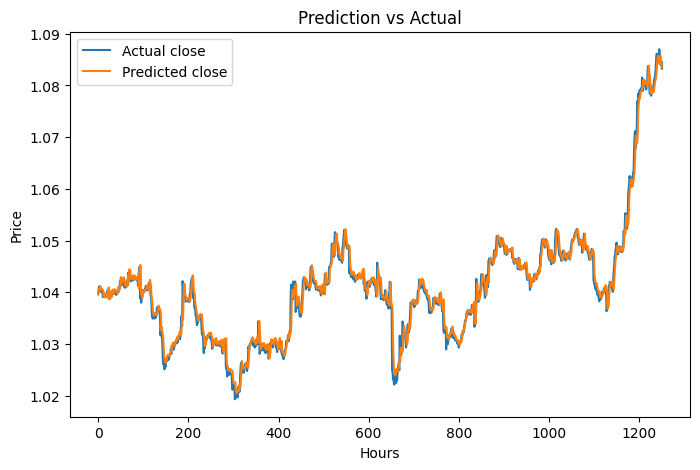

In [13]:
# Prédiction sur les données de test
predictions = history.model.predict(X_test)
predictions = dataset.target_scaler.inverse_transform(predictions)  # Inverser la normalisation

# Comparaison des prédictions avec les vraies valeurs
y_test_actual = dataset.target_scaler.inverse_transform(y_test.reshape(-1, 1))

#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Prediction vs Actual')
plt.xlabel('Hours')
plt.ylabel('Price')
plt.plot(y_test_actual,label = "Actual close")
plt.plot(predictions,label="Predicted close")
plt.legend()
plt.show()

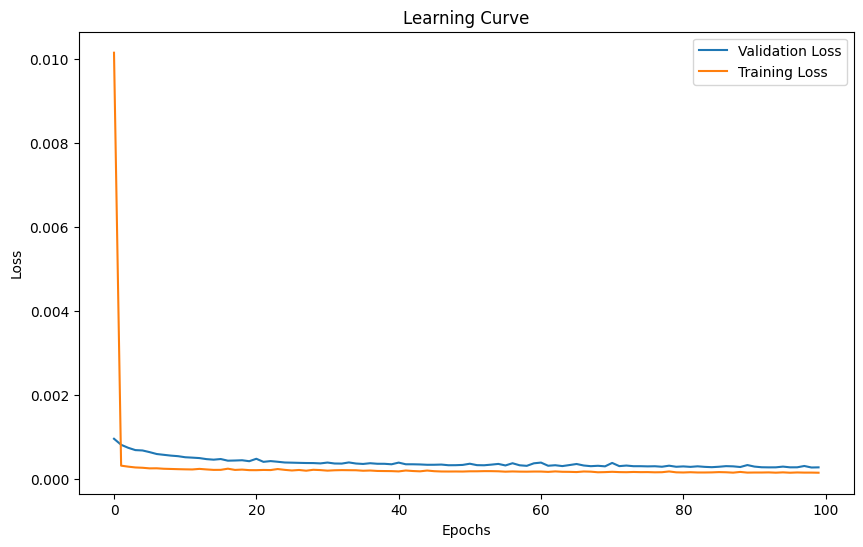

In [14]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Metriques d'évaluation

In [15]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# R2
print('RSquared : ', '{:.2%}'.format(r2_score(y_test_actual, predictions)))

Mean Squared Error: 2.909085908062273e-06
Mean Absolute Error: 0.0011567852970586407
Root Mean Squared Error: 0.0017056042647877827
RSquared :  97.90%


## Sauvegarde du model

In [ ]:
# history.model.save('../../models/test/best_model_EURUSD.keras')
# print('Model saved!!')

Model saved!!


In [17]:
# ts.to_csv('../../notebooks/inference/datasets/eur_usd_2024_03_2025.csv', index=True)